---
Title: On the use of hierarchical models in software metrics studies: a replication and tutorial.
Title: Bayesian Replication of SATT threshold paper
Author: Neil Ernst
---


# Intro
[Aniche et al. postulated](http://www.mauricioaniche.com/2016/08/scam-2016-satt-tailoring-code-metric-thresholds-for-different-software-architectures/) that the *architectural role* a class plays influences the expected value of certain software metrics. In particular, whether a class was a controller, repository, or view should change its CK metric values. For example, since a controller is interacting with views and models, presumably it should be more coupled. Their paper shows that this does seem to be the case. Luckily, nicely, they make the dataset and scripts [available for download](https://mauricioaniche.github.io/scam2016/).

I wanted to replicate this analysis using a hierarchical model. A hierarchical model is a way of modeling data using >1 *level*. The classical examples are [radon](http://mc-stan.org/documentation/case-studies/radon.html) and school performance. In the radon case, you have samples of radon (a colorless, odorless gas emitted from the earth) that are collected per house. We would like to make inferences about radon distributions across a state, so we could either just map out all the individual samples, or, using some knowledge of county distributions, we could use those to infer radon levels for places with fewer samples. For example, a county with one (outlier) sample we can *pull* back using the data from surrounding counties.

This lends itself to a Bayesian analysis, and since I am learning Pandas and Stan, I thought it would make a nice case study to replicate this. Andrew Gelman covered this type of scenario directly [here](http://andrewgelman.com/2016/03/01/hes-looking-for-a-textbook-that-explains-bayesian-methods-for-non-parametric-tests/), and states "Just model what you want to model directly, and forget about the whole null hypothesis significance testing thing". So that's what I'll do.[^2]

# Background: Bayesian Mixture Models
For a general introduction to a Bayesian approach to statistics, people can refer to \cite{gelman14} and \cite{mcilreath16}. In general, however, a Bayesian approach allows us to ask the question "What is the probability my hypothesis is true, conditional on the data". This follows from the standard Bayes theorem, $\frac{P(H | D) = P(D | H) * P(H)}{P(D)}$, where H is our hypothesis (i.e., architectural role influences software metrics), and D is the data we gather. $P(H~|~D)$ is the *posterior probability* we are ultimately interested in, $P(D | H)$ is the *likelihood*, and $P(H)$ is our *prior probability*. We must explicitly assign a prior probability in Bayesian statistics, which can range from *uninformative*, i.e., we claim no knowledge about what it should be, to strongly informative (we have a high confidence, e.g. from other studies, in probability of H). The strength of our prior can be thought of as the extent to which new data influences our posterior. Bayesian analysis derives a posterior probability distribution for our unknown parameters (e.g., $\mu$ and $\sigma$ for a normal distribution). The tools introduced in this paper explain how this is done, and how much variation we should see in the result.

<!-- Contrast this with a frequentist or traditional approach. There we propose a null hypothesis $H_0$, and, based on assumptions that are typically unexplored, assign to that a probability distribution based on the observed data. We then conduct a statistical test to see if the outcome we observed in our sample can be explained by the null hypothesis being true. Typically "explained by" implies that this sample lies within 95\% of the probability density. Note that this being *false* does not imply our alternate hypothesis is true; merely that our null hypothesis is not explaining this result (very well). -->

## Background: Probabilistic Programs
Probabilistic programming is a programming paradigm that uses an underlying inference engine to fit complex, multi-level models. The most obvious difference from traditional programming is that variables are not determinitist but rather stochastic; their value comes from a probability distribution. 

A multi-level or hierarchical model is one in which the distribution of the underlying parameters is itself something to be estimated from the data (hyper-parameters or hyper-priors). 

It is only recently that computational power has caught up to the promise of probabilistic programs. For example, to calculate the fit for the pooled model (discussed below) requires 2 minutes on a 2017 laptop.

A good survey of probabilistic programming is available at:

By contrast with the programming most readers are familar with, probabilistic programs are declarative and statistical. This means we define upfront what we believe the predictor can be modeled as, typically using some statstical models; we then turn to the inference engine to simulate some reasonably large number of draws against that declared model, typically using a variant of Markov Chain Monte Carlo estimators. The MCMC approach uses random sampling, optimization to condition model parameters on the prior data.

One example of a probabilistic programming lanauge (and the one I use) is Stan, and its PyStan library for the Python ecosystem. A Stan probablistic program looks like

```
model {
  y ~ normal(beta[1] + beta[2] * x, sigma);
}
data {
  int<lower=0> N; 
  vector[N] x;
  vector[N] y;
}
parameters {
  vector[2] beta;
  real<lower=0> sigma;
} 
```
where we provide input for the data section (i.e. our vector of LCBO values), and the probablistic program is asked to find values for the parameters section that optimize for our model, conditioned on the data.

We then call on PyStan to compile and sample the model

```
compiled_model = pystan.stanc(model_code=pooled_data + pooled_parameters + pooled_model)
model = pystan.StanModel(stanc_ret=compiled_model)
pooled_fit = model.sampling(data=pooled_data_dict, iter=1000, chains=2)

pooled_sample = pooled_fit.extract(permuted=True)
```

the variable `pooled_fit` represents the sampled model using 2 runs of 1000 MCMC iterations; this produces a sample of 2000 potential values for our parameters (the posterior distribution), from which we then extract the means.

# Data collection
First, to more strictly replicate or not? I could re-use the projects they did, but that might bias me. On the other hand, they've done the hard work, and this way I can directly compare to their results.

Mauricio has provided all his data on Github, so we can load it directly into Pandas (thanks Mauricio!). Then we can check some of the data characteristics. In this replication I will focus on two variables, namely coupling between objects (CBO) and lines of code (LOC) as well as architectural role (role). 

The central RQ of the SATT paper is 

> What differences in metric values distributions does SATT find for common architectural styles such as MVC? 

They use classes from Java Spring projects. Spring has 6 types of roles: (`Controller, Repository, Service, Entity, Component, Others`). Now the question that is being asked to some extent requires a comparison of CBO distribution per architectural role. The SATT finding, after using a classical Wilcoxon non-parametric test, was that role played a significant part in eventual CBO numbers. To wit:

> This coupling metric presents medium and large effect sizes in almost all architectural roles, with the exception of REPOSITORIES and ASYNCTASKS, which present small effect size. We highlight CONTROLLERS, which have a large effect size, and in the boxplot, we can see that their median is higher than that of other classes.

What I want to confirm (with their own data!) is whether this finding of large effect size holds up under a bayesian, hierachical modeling approach. 

The first question to answer is what we mean by 'effect size' under a hierarchical/partial pooling approach. Effect size doesn't mean much in the Bayesian world. Effect size in the frequentist world means 

One thing to note about the original study is that the findings are dependent on the analysis choices the authors made. Bonferroni correction was applied but we are left with a finding of 8 large effects out of 25 comparisons made (5 architectural roles X 5 metrics). Bonferroni essentially just lowers the 'significance' level, but does nothing to correct for forking paths. In other words, another dataset might reveal another (different) 8 combinations as significant, and we would expect the same results. And as expected, we see some story-telling tieing these results into some software engineering theory (post-hoc justification). What would be better? For quantitative analysis such as this, I would expect:

1. predefined constructs and reasonable null hypothesis defined ahead of time, using some SE theory. For example, "since controllers are middleware, they should have a large CBO metric". Then test that.
2. (preferably) properly define assumptions (as priors) and infer from a probability mass distribution whther there is something interesting going on, using a Bayesian analysis. 

I'll also use this opportunity to complain about how researchers in Software Engineers report their results. Table 1 reports a Cliff's Delta analysis (a non-parametric comparison of ranks) for each pairwise comparison of Metrix X and Role Y. But what does 'large effect' mean for the authors? What would we expect to see? Most readers are statistically unsophisticated, and won't understand any of the assumptions underlying Cliff's Delta, nor what effect size means in that context. Finally, there is no power analysis to allow us to understand whether this test was even likely to find a significant effect.

In [3]:
%matplotlib  inline  
#inline
import pandas as pandas
import cliffsDelta.cliffsDelta as cd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as scipy
import scipy.stats as stats
import pystan
import statsmodels.api as sm
import find_fit
import powerlaw

/Users/nernst/anaconda/envs/nn/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


First, a bit of data cleaning. I want to eventually use the lines of code as a predictor, so we merge that into the original metrics data. Some rows are missing either a metric or a LOC count, so we drop those.

In [4]:
roles = {0:"none",1:"controller", 2:"dao", 3:"service", 4:"entity", 5:"component"}
roles_lst = list(roles.values())
# roles_num = range(len(roles))
# role_dict = dict(zip(roles_num, roles))
spring_columns = ["project", "file", "class", "type", "test", "role", "cbo", "dit", "lcom", "noc", "nom", "rfc", "wmc"]

# load data
# N = 63525
spring = pandas.read_csv('data/metrics/spring.csv', header=None, names=spring_columns)
# N = 60701
sloc = pandas.read_csv('data/metrics/spring-sloc2-java.csv', usecols=['loc','file'])

# inner = drop NaN values
# N = 59760
final = spring.merge(sloc, on='file', how='inner')
# final.replace({'role': role_dict}, inplace=True)
# Strict replication would need to use DataFrame 'spring' and not 'final', due to merge
cbo_pop = final.loc[:,['test','type','cbo','role','loc']]
cbo_pop_controller = cbo_pop.query("test == 0 and type == 'class' and role != 1")

cbo_controller = cbo_pop.query("role == 1")
data = pandas.Series(cbo_controller['cbo'])
final.cbo


,project,file,class,type,test,role,cbo,dit,lcom,noc,nom,rfc,wmc,loc
0,tatami-team1,/media/dsk1/webapps-springmvc/tatami-team1/src...,fr.ippon.tatami.domain.validation.ContraintsUs...,interface,0,0,0,1,0,0,0,0,0,3
1,tatami-team1,/media/dsk1/webapps-springmvc/tatami-team1/src...,fr.ippon.tatami.repository.cassandra.Cassandra...,class,0,2,18,1,0,0,4,36,26,101
2,tatami-team1,/media/dsk1/webapps-springmvc/tatami-team1/src...,fr.ippon.tatami.service.UserService,class,0,3,17,1,0,0,13,58,38,210
3,tatami-team1,/media/dsk1/webapps-springmvc/tatami-team1/src...,fr.ippon.tatami.service.GroupService,class,0,3,15,1,0,0,8,50,26,132
4,tatami-team1,/media/dsk1/webapps-springmvc/tatami-team1/src...,fr.ippon.tatami.security.TatamiUserDetails,class,0,0,1,2,0,0,4,0,4,23


In [169]:
(final.cbo).describe()

count    56106.000000
mean         6.865184
std          7.486489
min          0.000000
25%          2.000000
50%          5.000000
75%          9.000000
max        154.000000
Name: cbo, dtype: float64

In [5]:
final.loc[:,["project"]]
len(final.query("project=='tatami-team1'"))

141

We have 120 projects in the \cite{aniche16} dataset, and a wide range of values for N (number of files). Some projects are very tiny. The total file count of the smallest is 28, and the number of controller files (for example) is 18.

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


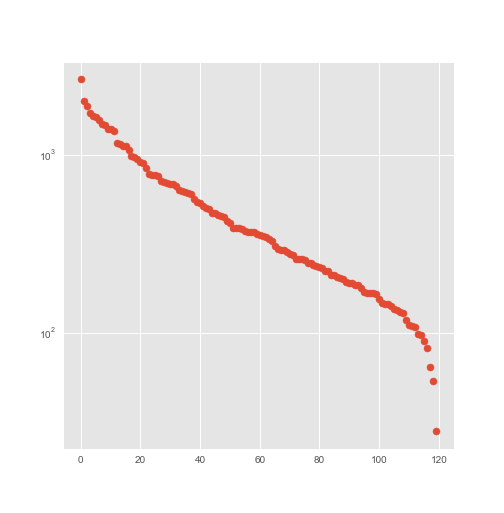

18

In [152]:
# show the values of N
s = pandas.Series(spring['project']).value_counts() 
ax = plt.gca()
ax.scatter(range(len(s)),s)
ax.set_yscale('log')
# find number of controllers in smallest
twogx_df = spring[spring['project'] == '2gx_demo']
len(twogx_df[twogx_df['role'] == 1]) # 18

In [8]:
projects = final.project.str.strip().unique()
proj_num = len(projects)
project_lookup = dict(zip(projects, range(proj_num)))
project = final['proj_code'] = final.project.replace(project_lookup).values
role_code = final.role

# reshape the Role field into onehot encoding (binarized)
# an array of size 6 where a 1 indicates True for each role
import sklearn.preprocessing as pp
lb = pp.LabelBinarizer().fit(role_code.values.reshape(-1,1))
binarized = lb.transform(role_code)
temp = pandas.DataFrame(binarized,columns=roles_lst)
#using indices assumes equal size
final = final.merge(temp,left_index=True,right_index=True)

### for testing
# final = final[final.proj_code < 10]
# project = final['proj_code'] = final.project.replace(project_lookup).values
# projects = final.project.str.strip().unique()
# proj_num = len(projects)
# project_lookup = dict(zip(projects, range(proj_num)))
# role_code = final.role
###

In [9]:
final.head()

,project,file,class,type,test,role,cbo,dit,lcom,noc,...,loc,log_cbo,log_sloc,proj_code,none,controller,dao,service,entity,component
0,tatami-team1,/media/dsk1/webapps-springmvc/tatami-team1/src...,fr.ippon.tatami.domain.validation.ContraintsUs...,interface,0,0,0,1,0,0,...,3,-2.302585,1.131402,0,1,0,0,0,0,0
1,tatami-team1,/media/dsk1/webapps-springmvc/tatami-team1/src...,fr.ippon.tatami.repository.cassandra.Cassandra...,class,0,2,18,1,0,0,...,101,2.895912,4.616110,0,0,0,1,0,0,0
2,tatami-team1,/media/dsk1/webapps-springmvc/tatami-team1/src...,fr.ippon.tatami.service.UserService,class,0,3,17,1,0,0,...,210,2.839078,5.347584,0,0,0,0,1,0,0
3,tatami-team1,/media/dsk1/webapps-springmvc/tatami-team1/src...,fr.ippon.tatami.service.GroupService,class,0,3,15,1,0,0,...,132,2.714695,4.883559,0,0,0,0,1,0,0
4,tatami-team1,/media/dsk1/webapps-springmvc/tatami-team1/src...,fr.ippon.tatami.security.TatamiUserDetails,class,0,0,1,2,0,0,...,23,0.095310,3.139833,0,1,0,0,0,0,0


In [103]:
# clean projects with no controllers
print (len(final))
for name in projects:
    query_string = "project == '"+ name + "' and controller == 1"
    num = len(final.query(query_string))
    if num == 0: # no controllers, hard to do regression
        final.drop(final[final.project==name].index,inplace=True)
print("after: " + str(len(final)))

59070
after: 56106


In [10]:
# remove Zeros for log to work
epsilon = 0.1
cbo = final.cbo
final['log_cbo'] = log_cbo = np.log(cbo + epsilon).values
sloc = final['loc']
final['log_sloc'] = log_sloc = np.log(sloc + epsilon).values


The violin plot can show us a rough sense for how the data is distributed. We'll plot it on a log scale for CBO (adding $\epsilon=0.1$ to the zeros, which is not necessarily the best idea). The log transformed value will then be known as LCBO. See [Modeling the Spike at Zero](#spikezero)

<IPython.core.display.Javascript object>


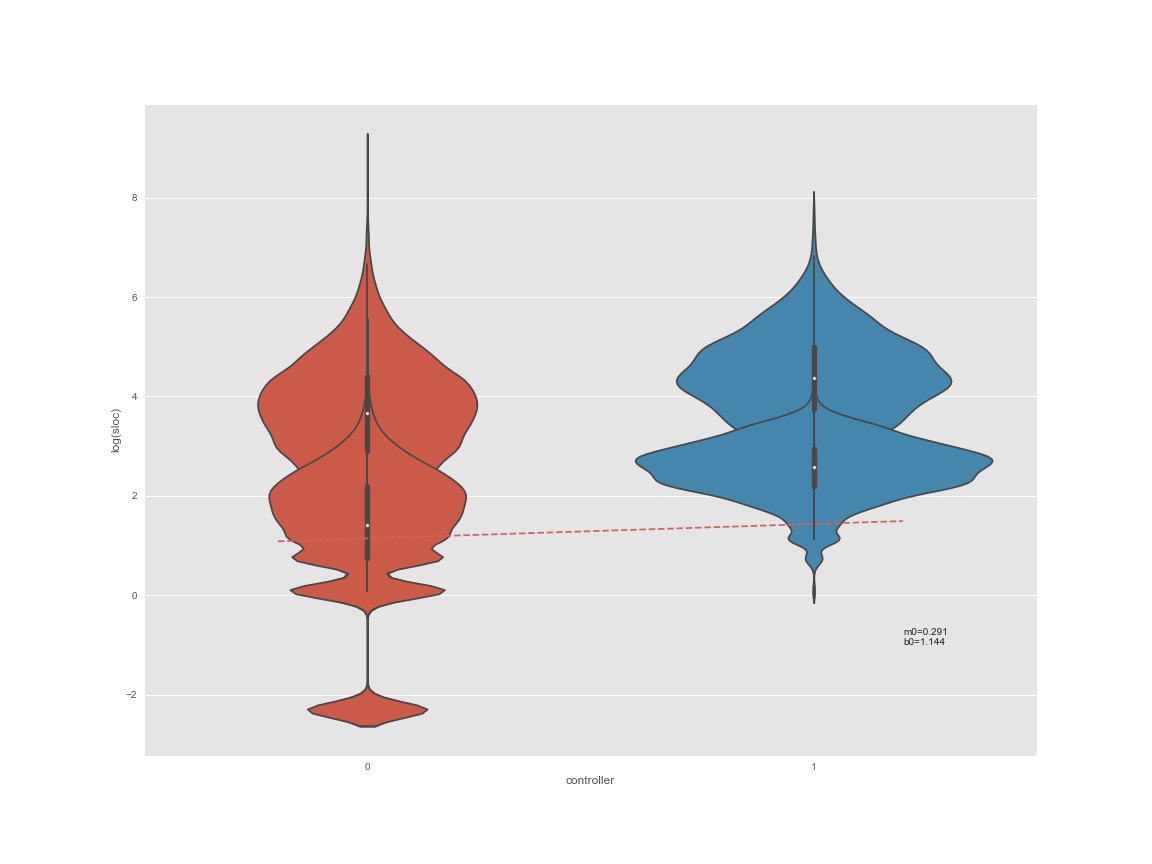

In [153]:
#sns.stripplot(df['role'],df['cbo'], data=df, jitter=True)
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax = sns.violinplot(role_code, log_cbo, ax=ax1) #, data=final,
ax.set_ylabel('log(cbo)')
fig.savefig('violin.pdf')

Text(0,0.5,'log(sloc)')

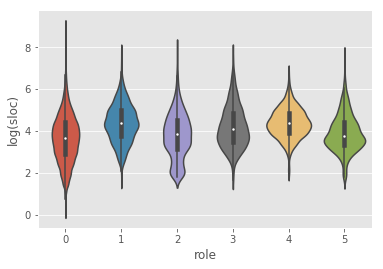

In [11]:
ax = sns.violinplot(role_code, log_sloc)
ax.set_ylabel('log(sloc)')

## A Multi-Level Model
The original approach was to compare each of the 5 roles against the *entire* set of remainig files for the CBO metric. This pairwise comparison was evaluated with the Wilcoxon test (R's `wilcox.test` function, to be exact). I think this is equivalent to the Mann-Whitney test.  Let's try to replicate that result for these files. 

As a sanity check of the Python Cliff's Delta calc, let's look at the Controller vs Population calculation from the paper. Table 1 reports CBO for Controller vs Pop of 0.6591.

In [21]:
# compare CBO of Role=Controller to CBO of remainder
mann_dict = {}
cliff_dict = {}
vals = range(1,6)
for role in vals:
    for role2 in vals:
        first = cbo_pop[(cbo_pop.role == role)]
        other = cbo_pop[(cbo_pop.role == role2)]
        key = roles[role] +'-'+ roles[role2]
        mann_dict[key] = stats.mannwhitneyu(first['cbo'],other['cbo'])
        cliff_dict[key] = cd.cliffsDelta(first['cbo'],other['cbo'])
delta, effsize = cd.cliffsDelta(cbo_controller['cbo'],cbo_pop_controller['cbo'])
statistic, pvalue = stats.mannwhitneyu(cbo_pop_controller['cbo'],cbo_controller['cbo'])

In [137]:
print(cd.cliffsDelta(cbo_controller['cbo'],cbo_pop_controller['cbo']))
print(scipy.stats.mannwhitneyu(cbo_pop_controller['cbo'],cbo_controller['cbo']))


(0.6568747452072136, 'large')
MannwhitneyuResult(statistic=21493069.5, pvalue=0.0)


The effect is not identical because I have merged the original data with the SATT line of code data. You can see the difference in row counts above. But the values are pretty similar. 

## Choosing a Probability Distribution
The choice of a non-parametric test here is a bit strange. These are clearly not ordinal data (integer valued CBO, now floating point values with the use of `log`). And the author's own paper, in the conclusion, states that other research has discovered log-normal, Pareto, and "double Pareto" (combined log-normal and Pareto tails). The advantage of a parameteric model is that we can begin to apply more powerful statistical approaches to the data. It is reasonably easy to figure out what a reasonable probability distribution could be (the parametric part describes the location and shape of the distribution, i.e., its mean and variance in the case of the normal distribution). 
 
Other researchers (notably \cite{Herraiz2012}) have claimed a 'double-pareto'---double Pareto-logNormal---model best explains the data they looked at (Java source code from the Qualitas corpus). This is a model with a lognormal head and a powerlaw tail. There is no obvious encoding of this in the tools I used, and it makes the later models more complex to understand. For now, I stick with the lognormal.

Note that the SATT approach was to use non-parametric test (Mann-Whitney and Cliff's Delta) to characterize the differences. This is probably because they knew that CBO was not normally distributed. But the beauty of the Bayes approach is that we can *explicitly* model that in the code.

My approach to fitting the data with a theoretical distribution (Poisson, Gamma, Weibull, Normal, LogNormal etc), is to mix what the literature suggests with what the data suggest. In this case, lognormal models the notion that the bulk of the values are in the left (lower) end of the CBO values, with diminishingly probabilty of higher values. A Normal distribution models the idea that most of the probability mass is clustered to either side of the mean. From the software literature, we know (cite) that software metrics (such as LOC) are often expontnatially distributed: this captures the intuitiopn that most code is in small files, with a few extreme outliers. 

We see something like this in the violin plots. 

Calculating best minimal value for power law fit
/Users/nernst/anaconda/envs/nn/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/Users/nernst/anaconda/envs/nn/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


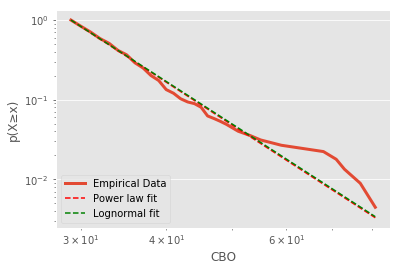

In [11]:
# first, the lognormal
data = pandas.Series(cbo_controller['cbo'])
fit = powerlaw.Fit(data, discrete=True)
####
fit.distribution_compare('power_law', 'lognormal')
fig = fit.plot_ccdf(linewidth=3, label='Empirical Data')
fit.power_law.plot_ccdf(ax=fig, color='r', linestyle='--', label='Power law fit')
fit.lognormal.plot_ccdf(ax=fig, color='g', linestyle='--', label='Lognormal fit')
####
fig.set_ylabel(u"p(X≥x)")
fig.set_xlabel("CBO")
handles, labels = fig.get_legend_handles_labels()
fig.legend(handles, labels, loc=3)

figname = 'FigLognormal'
# savefig(figname+'.eps', bbox_inches='tight')
#savefig(figname+'.tiff', bbox_inches='tight', dpi=300)


/Users/nernst/anaconda/envs/nn/lib/python3.6/site-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


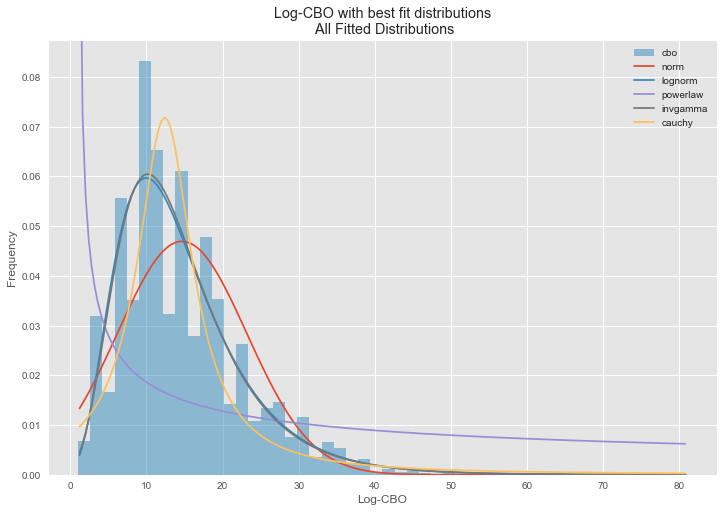

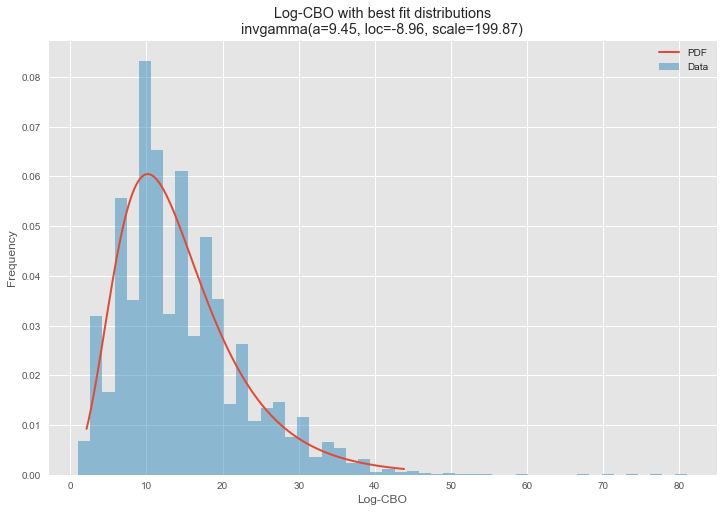

In [121]:
import importlib
importlib.reload(find_fit)
find_fit.plot_fits(pandas.Series(data), title='Log-CBO with best fit distributions', xlab='Log-CBO')
# plt.savefig('fit-distr.pdf', dpi=300)



This tells us to use an inverse gamma, but the Normal (of the log data) is almost as good a fit. We can also use the probplot approach with Quantile-Quantile graphs. Here we compare our data to the theoretical model of each distribution. A perfect fit implies a diagonal 45 degree match. QQ plots show divergence from the predicted (theoretical) values. 

Text(0.5,0.98,'LogNormal QQ-SLOC')

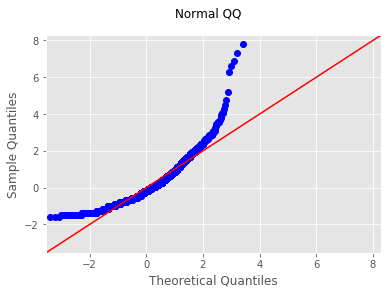

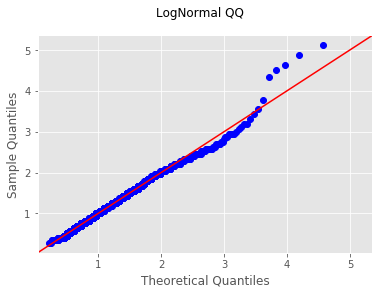

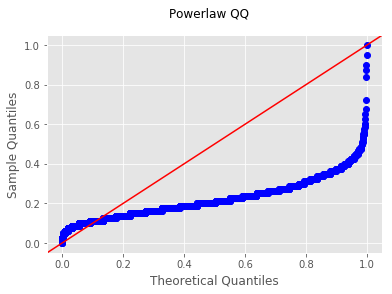

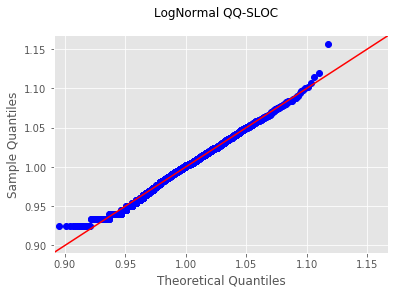

In [13]:
# using StatModels
fig1 = sm.qqplot(data, stats.norm, fit=True, line='45')
fig1.suptitle('Normal QQ')
fig2=sm.qqplot(data, stats.lognorm, fit=True, line='45')
fig2.suptitle('LogNormal QQ')
fig3 = sm.qqplot(data, stats.powerlaw, fit=True, line='45')
fig3.suptitle('Powerlaw QQ')
fig4 = sm.qqplot(log_sloc, stats.lognorm, fit=True, line='45')
fig4.suptitle('LogNormal QQ-SLOC')

There's some weirdness down at the extreme end---this is where the powerlaw fit would likely be more suitable. The QQ plot is showing that the actual values are greater than predicted by a lognormal curve would show (recall that the lognormal is modeled by  $X \sim e^Y$).  For the purposes of the remainder of the paper, however, it does not detract from the argument to consider the log of the metric values.

# Multi-level models
In general, the approach taken in the SATT paper is to compare, using a non-parametric test, the ordered list of metric values for a given architectural role against (a) a single other architectural role and (b) all other data. The authors used the results to suggest that there is a significant difference in metric scores (CBO, in our case) given a particular architectural role.

Two things are unsatisfying with this approach. One, it does not make use of the lognormal distribution of the data to conduct a more substantive analysis of the data. Two, the large degrees of researcher freedom make it uncertain whether such a result is replicable.

Multilevel or *hierarchical* models allow us to treat this problem differently. One way to reprhase the problem in a parametric format is to ask whether the distribution parameters (brodaly, shape and location of central tendency; in the normal case, mean and variance (sigma)) are different from one set of data to another. There are frequentist tests, such as the two-tailed t-test, that could do this; another way is to fit a regression line to the data and evaluate to what extent the regression coefficients (the line's *slope* and *intercept*) differ. 

Here are three ways to do this.

## Background: STAN and probabilistic programming
STAN is a probabilistic programming language. Probabilistic programming uses statistical models to 

## The Prediction Task
Our task is to predict a given project's mean LCBO score. Our predictor is the file's architectural role; later, we can add a predictor using lines of code. THe hyp, we would expect (based on Aniche et al) that (log) CBO would be higher given 
<!--all else equal, a file with more LOC is expected to have more coupling. -->

The hierarchy in this example is files within projects.  

## Full Pooling
Full pooling is a global assessment of differences. We don't divide our dataset at all, but rather look at a single regression model. We predict CBO score, $y$, as a function of role (see the extension below for the addition of SLOC as a predictor):
$ y_i = \alpha + \beta x_i + \epsilon_i$


First, we model the data in Stan. Here I follow the model approach described by [Chris Fonnesbeck](https://github.com/fonnesbeck/stan_workshop_2016/blob/master/notebooks/Multilevel%20Modeling.ipynb)

In [46]:
pooled_data = """
data {
  int<lower=0> N; 
  vector[N] x;
  vector[N] y;
}
"""


5


Initialize the parameters, which in this case are the linear model coefficients and the normal scale parameter. 

In [23]:
pooled_parameters = """
parameters {
  vector[2] beta;
  real<lower=0> sigma;
} 
"""

Finally, using the standard normal linear model, we know that all responses y can be modeled as a normal disttirubtion whose mean is the linear function of x, and whose variance sigma is constant. Accordingly, we model the log-CBO measurements as a normal (lognormal distribution, hence normal of the log) distribution with a mean that is a function of the role played.


In [24]:
pooled_model = """
model {
  y ~ normal(beta[1] + beta[2] * x, sigma);
}
"""

We then pass the code, data, and parameters to the stan function. The sampling requires specifying how many iterations we want, and how many parallel chains to sample. Here, we will sample 2 chains of length 1000. 

In [25]:
pooled_data_dict = {'N': len(log_cbo),
               'x': role_code,
               'y': log_cbo}

compiled_model = pystan.stanc(model_code=pooled_data + pooled_parameters + pooled_model)
model = pystan.StanModel(stanc_ret=compiled_model)
pooled_fit = model.sampling(data=pooled_data_dict, iter=1000, chains=2)

pooled_sample = pooled_fit.extract(permuted=True)
# we assume the resulting sample is normally distributed
b0, m0 = pooled_sample['beta'].T.mean(1)




INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_dd6a876b770652d53bdcc0546345af4b NOW.


In the Bayesian context, what we have created is a probability distribution on the posterior values (the unknown parameters $\beta$ and $\sigma$). We aren't getting point estimates, but rather distributions. Hence, in order to get a sense for what the probability masses around (due to the central limit theorem, we get normal distributions for these parameters). Thus we sample from the posterior distribution represented by $\textsf{pooled_fit}$ and show the range of values.

I then plot the values as a regression line, using the new parameters b0 and m0 for the slope and intercept of the regression line.

In [41]:
pooled_sample



OrderedDict([('beta', array([[ 1.14132711,  0.28853798],
                     [ 1.15348014,  0.28498127],
                     [ 1.15006676,  0.29148923],
                     ..., 
                     [ 1.1484578 ,  0.28767416],
                     [ 1.14663044,  0.28932141],
                     [ 1.13355407,  0.29636937]])),
             ('sigma',
              array([ 1.37100171,  1.36354081,  1.36477167,  1.36106147,  1.37041398,
                      1.37082843,  1.36149319,  1.3615697 ,  1.3676795 ,  1.36347405,
                      1.36543335,  1.36838302,  1.36546776,  1.36240414,  1.36504914,
                      1.36056378,  1.36337877,  1.36721359,  1.36282363,  1.36651952,
                      1.36013791,  1.36297033,  1.37400626,  1.36815279,  1.36251117,
                      1.35469873,  1.36532117,  1.36566979,  1.36728267,  1.35621875,
                      1.36604901,  1.36251257,  1.37049377,  1.35404363,  1.36000207,
                      1.3626712 ,  1.359040

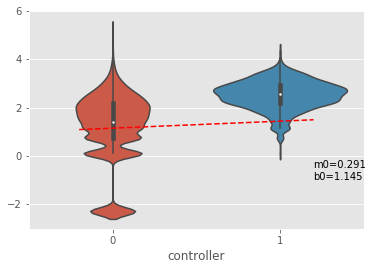

In [45]:
#plt.scatter(final.controller, log_cbo)
fig = plt.figure()
ax1 = fig.add_subplot(111)

import seaborn as sns
# in the violinplot, "0" means "not controller" which is a bit different from the original paper
ax = sns.violinplot(final.controller, log_cbo)
xvals = np.linspace(-0.2, 1.2)
ax.plot(xvals, m0*xvals+b0, 'r--')
plt.text(1.2,-1,"m0={0:.3f}\nb0={1:.3f}".format(m0,b0))

fig.savefig('pooled-regress.pdf')



The interpretation of this regression result says that in a pooled model, we would expect an average LCBO of 1.144 (CBO of 3.14) if there were no controllers; and the controller predictor causes a `exp(0.0291)= 1.03` increase in CBO.

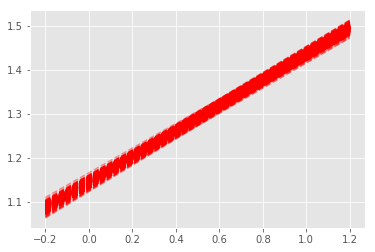

In [64]:
# here we plot several of the samples to show the variance sigma
fig = plt.figure()
ax1 = fig.add_subplot(111)
xvals = np.linspace(-0.2, 1.2)
for i in range(1000):
    bi,mi = pooled_sample['beta'][i]
    ax1.plot(xvals, mi*xvals+bi, 'r--',alpha=0.4)


# fig.savefig('pooled-regress.pdf')


1.1534801437599496

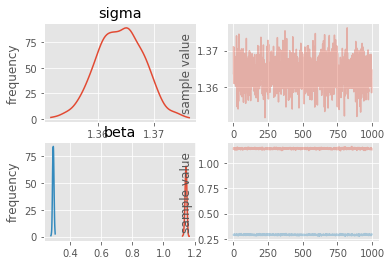

In [50]:
pooled_fit.plot(pars=['sigma', 'beta']);

In [51]:
print(pooled_fit)

Inference for Stan model: anon_model_dd6a876b770652d53bdcc0546345af4b.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0]   1.14  2.5e-4 6.0e-3   1.13   1.14   1.15   1.15   1.16    565    1.0
beta[1]   0.29  1.7e-4 4.5e-3   0.28   0.29   0.29   0.29    0.3    692    1.0
sigma     1.36  1.3e-4 4.1e-3   1.36   1.36   1.36   1.37   1.37   1000    1.0
lp__    -4.8e4    0.06   1.23 -4.8e4 -4.8e4 -4.8e4 -4.8e4 -4.8e4    464    1.0

Samples were drawn using NUTS at Fri Jan 26 15:21:34 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [52]:
scipy.stats.linregress(role_code,log_cbo)

LinregressResult(slope=0.29050646309129868, intercept=1.1445966030856813, rvalue=0.25923107996587469, pvalue=0.0, stderr=0.0044275264309076015)

## Unpooled
We could go to the other extreme, and model the data per project (120 projects). Each project gets a separate regression model, and we can compare the co-efficients for each one.

$y_i = \alpha_{i[j]} + \beta x_i + \epsilon_i $

The difference between these two approaches is a bias-variance tradeoff. In the fully pooled model, we bias the data to the larger instances (the value for the number of files per project, which is our number of uinique measures, range from 26 files to 2677 files). The subtle variance per project, which may demonstrate confounding effects (e.g., that some unmodeled predictor is partly responsible for the value of LCBO), is ignored in this model.

By contrast, in the unpooled approach, we allow total variance, at the expense of high variance (and possibly misleading data) in the smaller samples. McIlreath (\cite{mcilreath16}) calls this "anterograde amnesia" since we 'forget' what we learned from the previous projects. 

In [12]:
len(project)

59761

In [13]:
# unpooled *change 10 to 120 in production*
unpooled_model = """
data {
  int<lower=0> N; 
  int<lower=1,upper=120> project[N];
  vector[N] x;
  vector[N] y;
} 
parameters {
  vector[120] a;
  real beta;
  real<lower=0,upper=100> sigma;
} 
transformed parameters {
  vector[N] y_hat;

  for (i in 1:N)
    y_hat[i] = beta * x[i] + a[project[i]];
}
model {
  y ~ normal(y_hat, sigma);
}
"""

unpooled_data = {'N': len(log_cbo),
                 'project': project+1,  # Stan counts starting at 1
                 'x': final.controller,
                 'y': log_cbo}

compiled_unpooled_model = pystan.stanc(model_code= unpooled_model)
unpooled_model = pystan.StanModel(stanc_ret=compiled_unpooled_model)
unpooled_fit = unpooled_model.sampling(data=unpooled_data, iter=1000, chains=2)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_85323bbd8048b26af680dcd2c3c6a28b NOW.


In [14]:
unpooled_estimates = pandas.Series(unpooled_fit['a'].mean(0), index=project_lookup)
unpooled_se = pandas.Series(unpooled_fit['a'].std(0), index=project_lookup)
order = unpooled_estimates.sort_values().index

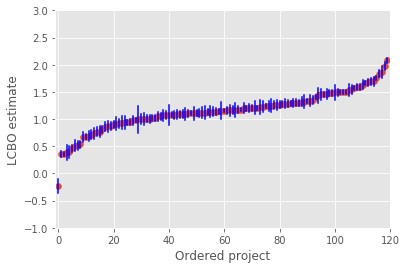

In [17]:
plt.scatter(range(len(unpooled_estimates)), unpooled_estimates[order])
for i, m, se in zip(range(len(unpooled_estimates)), unpooled_estimates[order], unpooled_se[order]):
    plt.plot([i,i], [m-se, m+se], 'b-')
#cahnge back to 120
plt.xlim(-1,120); plt.ylim(-1,3)
plt.ylabel('LCBO estimate');plt.xlabel('Ordered project');

In [18]:
unpooled_estimates['2gx_demo']

0.99364080153683221

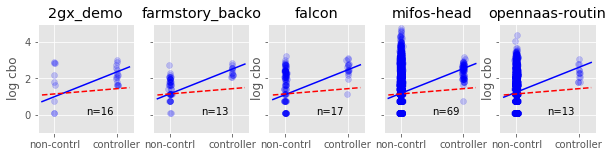

In [35]:
# sample_projects = list(project_lookup.keys())
# a set of projects with 1-3 being tiny, and 4-5 being large
wide_variance_proj = ['2gx_demo','farmstory_backoffice','falcon','mifos-head','opennaas-routing-nfv']

fig, axes = plt.subplots(1, 5, figsize=(10, 2), sharey=True, sharex=True)
axes = axes.ravel()
m = unpooled_fit['beta'].mean(0)
for i,c in enumerate(wide_variance_proj):
    y = final.log_cbo[final.project==c]
    x = final.controller[final.project==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.2, c='b')
    
    # No pooling model
    b = unpooled_estimates[c]
    
    # Plot both models and data
    xvals = np.linspace(-0.2, 1.2)
    interim = final.controller[final.project==c]
    n = pandas.Series(interim).value_counts()[1]
    axes[i].plot(xvals, m*xvals+b, 'b-') #unpooled
    axes[i].plot(xvals, m0*xvals+b0, 'r--') #pooled
    axes[i].set_xticks([0,1])
    axes[i].text(0.5,0,'n={}'.format(n))
    axes[i].set_xticklabels(['non-contrl', 'controller'])
    axes[i].set_ylim(-1, 5)
    axes[i].set_title(c[0:15])
    if not i%2:
        axes[i].set_ylabel('log cbo')

In [32]:
#final[final.project=c]
pandas.Series(interim).value_counts()

0    1871
Name: controller, dtype: int64

# Understanding the Differences
We now have two different models of what we would expect a file's LCBO to be. In the *pooled* approach, it is a function of the global distribution of CBO metric scores, averaged over all projects (i.e., we could say we understand CBO for a java file sampled at random from the original dataset). In the *unpooled* approach, a file's CBO score would be a function of the CBO distribution over all other files *in that project*. 

Neither is very satisfying. We know from previous research TODO CITATION NEEDED that software measurement is a highly contextual activity. Indeed, that is the very message of the original SATT paper. However, it would be silly to think that there was *no* global model that was applicable; developers, the Java language, the *naturalness* of software \cite{hindle} all suggest commonalities. Most importantly, some projects have very small N (number of files), so any measurement is going to exhibit a high degree of variance.

Let's see what that looks like. In the figure below, we are looking at a subset of 10 projects. In each plot you can see the value of N, where N = # of controller files (i.e., annotated with Spring's @controller mark).  The dashed red line is our regression line for the pooled model, and the blue line the unpooled (project specific) regression. It is clear that these two rarely line up well.

## Partial Pooling
Partial pooling, as you might expect, combines the two. It gives nuance we think exists because of local effects from architectural role, but weights that by the global mean. We are adjusting our local estimate *conditional* on the global estimate (which itself is conditioned on the new local values it encounters). The simplest approach to partial pooling is to take a weighted average and apply that to the global estimate. Smaller samples then have less impact on our global estimate.

If we instead think about our prediction task as a regression, another way to account for global trends in a local estimate is to vary either the slope of the regression line, or to vary the intercept of the line. Recall that our **global**/pooled regression equation predicts $y_i$, an observation at point i, to be 

$ y_i = \alpha + \beta x_i + \epsilon_i$


### Varying Intercept
Here we allow the intercept parameter $\alpha$ to vary with each project according to a random effect (random as in 'random variable').

In our unpooled model $y_i = \alpha_{i[j]} + \beta x_i + \epsilon_i $, we allowed the underlying Bayesian inference engine (Hamiltonian Monte Carlo) to estimate our parameters for the regression equation (i.e., $m_0$ and $b$). In a multilevel approach, rather than producing point estimates for these parameters, we instead model them with further probability distributions (i.e., the intercept $b$ of the regression for project $j$ is modeled as a normal distribution, whose parameters $\mu$ and $\sigma$ we now attempt to fit with the Bayesian inference engine (hyperparameters)).

Our regression model then adds a distributions for random/varying effects on the intercept $\alpha$:

$\alpha_{i[j]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2$) and models the individual project error $\epsilon_i$ as $\epsilon_i \sim N(0, \sigma^2_y$).

Read the expression $\epsilon_i \sim N(0, \sigma^2_y$) as "the error parameter epsilon is modeled by a Normal distribution with parameters mean = 0 and variance sigma squared". This is leveraging the probabilistic programming approach of simulating our posterior distribution using Hamiltonian Monte Carlo.


In [36]:

# i'm not clear why 100 is the uniform shape here
varying_intercept = """
data {
  int<lower=0> J; 
  int<lower=0> N; 
  int<lower=1,upper=J> project[N];
  vector[N] x;
  vector[N] y;
} 
parameters {
  vector[J] a;
  real b;
  real mu_a;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_y;
} 
transformed parameters {

  vector[N] y_hat;

  for (i in 1:N)
    y_hat[i] = a[project[i]] + x[i] * b;

}
model {
  sigma_a ~ uniform(0, 100);
  a ~ normal (mu_a, sigma_a);

  b ~ normal (0, 1);

  sigma_y ~ uniform(0, 100);
  y ~ normal(y_hat, sigma_y);
}
"""

In [37]:
varying_intercept_data = {'N': len(log_cbo),
                          'J': len(projects),
                          'project': project+1,  # Stan counts starting at 1
                          'x': final.controller,
                          'y': log_cbo}
varying_intercept_fit = pystan.stan(model_code=varying_intercept, data=varying_intercept_data, iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cd7c67c43e453abac639b25078fccf87 NOW.


In [29]:
len(sample_projects)

10

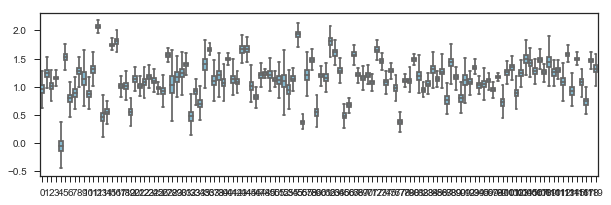

In [68]:
a_sample = pandas.DataFrame(varying_intercept_fit['a'])
sns.set(style="ticks", palette="muted", color_codes=True)

# Plot the orbital period with horizontal boxes
plt.figure(figsize=(10, 3))
sns.boxplot(data=a_sample, whis=np.inf, color="c")

The whisker plot shows how the intercept parameter $\alpha$ varies over the separate projects.

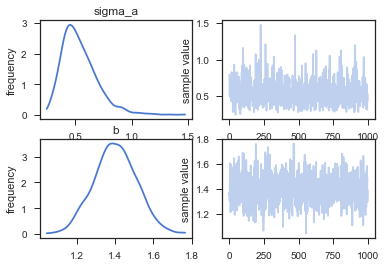

In [31]:
varying_intercept_fit.plot(pars=['sigma_a', 'b']);



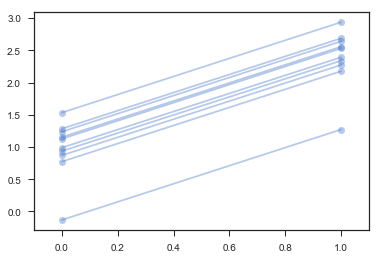

In [32]:
# varying_intercept_fit['b'].mean()
xvals = np.arange(2)
bp = varying_intercept_fit['a'].mean(axis=0) # intercept
mp = varying_intercept_fit['b'].mean() # slope = constant
for bi in bp:
    plt.plot(xvals, mp*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1,1.1);


The controller coefficient $\beta$/b has a value of 1.41, which can be interpreted as saying that Controllers in our dataset have a (exp(1.41)= 4.1 greater CBO value than non-Controller code. Recall that in this varying intercept model, this parameter b is fixed for all projects.

If we look at a comparison of the partially pooled, varying intercept model against the pooled estimate, we see how the estimates are more reasonable. The unpooled estimate is very similar: we did not allow slope to vary, and intercept is determined by the sufficiently large number of data points that are not controllers.

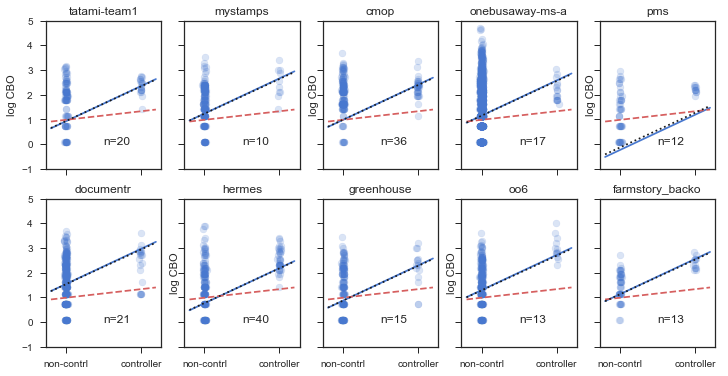

In [71]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()
m = unpooled_fit['beta'].mean(0)
for i,c in enumerate(sample_projects):
    y = final.log_cbo[final.project==c]
    x = final.controller[final.project==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.2, c='b')
    
    # No pooling model
    b = unpooled_estimates[c] 
    interim = final.controller[final.project==c]
    n = pandas.Series(interim).value_counts()[1]
    xvals = np.linspace(-0.2, 1.2)
    # Unpooled estimate
    axes[i].plot(xvals, m*xvals+b,'b-')
    # Pooled estimate
    axes[i].plot(xvals, m0*xvals+b0, 'r--')
    # Partial pooling estimate
    axes[i].plot(xvals, mp*xvals+bp[project_lookup[c]], 'k:')
    axes[i].set_xticks([0,1])
    axes[i].text(0.5,0,'n={}'.format(n)) 
    axes[i].set_xticklabels(['non-contrl', 'controller'])
    axes[i].set_ylim(-1, 5)
    axes[i].set_title(c[0:15])
    if not i%2:
        axes[i].set_ylabel('log CBO')

### Varying Slopes In Addition To Intercepts
Here, along with the varying intercept, we vary the slope parameter $\beta$ with each project. The practical impact of this will be to allow the projects to vary according to how the controller/non-controller predictor influences the reading. Our regression equation is 

$$y_i = \alpha_{j[i]} + \beta_{j[i]} x_{i} + \epsilon_i$$





In [69]:
varying_intercept_slope = """
data {
  int<lower=0> N;
  int<lower=0> J;
  vector[N] y;
  vector[N] x;
  int<lower=1,upper=J> project[N];
}
parameters {
  real<lower=0> sigma;
  real<lower=0> sigma_a;
  real<lower=0> sigma_b;
  vector[J] a;
  vector[J] b;
  real mu_a;
  real mu_b;
}

model {
  mu_a ~ normal(0, 100);
  mu_b ~ normal(0, 100);

  a ~ normal(mu_a, sigma_a);
  b ~ normal(mu_b, sigma_b);
  y ~ normal(a[project] + b[project].*x, sigma);
}
"""

In [67]:
varying_intercept_slope_data = {'N': len(log_cbo),
                          'J': len(projects),
                          'project': project+1,  # Stan counts starting at 1
                          'x': final.controller,
                          'y': log_cbo}

varying_intercept_slope_fit = pystan.stan(model_code=varying_intercept_slope, 
                                          data=varying_intercept_slope_data, 
                                          iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ae7d507da253e467cd9f7c15eb545bae NOW.


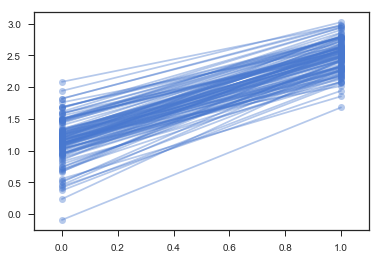

In [78]:
xvals = np.arange(2)
slopes_partial = varying_intercept_slope_fit['b'].mean(axis=0)
intercepts_partial = varying_intercept_slope_fit['a'].mean(axis=0)
for bi,mi in zip(intercepts_partial,slopes_partial):
    plt.plot(xvals, mi*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1, 1.1);
plt.savefig('slopes.pdf')

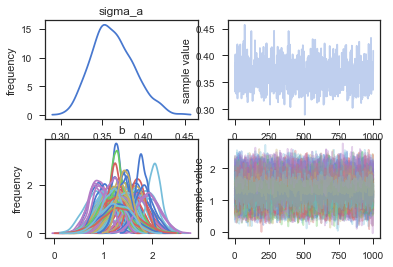

In [81]:
varying_intercept_slope_fit.plot(pars=['sigma_a', 'b']);
plt.savefig('eval-fit.pdf')

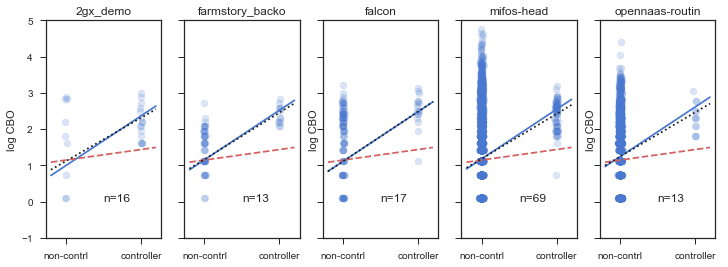

In [77]:
fig, axes = plt.subplots(1, 5, figsize=(12, 4), sharey=True, sharex=True)
axes = axes.ravel()
slope_unpooled = unpooled_fit['beta'].mean(0)
intercept_pooled, slope_pooled = pooled_sample['beta'].T.mean(1)

for i,c in enumerate(wide_variance_proj):
    y = final.log_cbo[final.project==c]
    x = final.controller[final.project==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.2, c='b')
    
    # Unpooled model has project-specific intercept, global slope
    intercept_unpooled = unpooled_estimates[c] 
    
    interim = final.controller[final.project==c]
    n = pandas.Series(interim).value_counts()[1]
    xvals = np.linspace(-0.2, 1.2)
    
    # Unpooled estimate
    axes[i].plot(xvals, slope_unpooled*xvals+intercept_unpooled,'b-')
    # Pooled estimate
    axes[i].plot(xvals, slope_pooled*xvals+intercept_pooled, 'r--')
    # Partial pooling estimate
    axes[i].plot(xvals, slopes_partial[project_lookup[c]]*xvals+intercepts_partial[project_lookup[c]], 'k:')
    
    axes[i].set_xticks([0,1])
    axes[i].text(0.5,0,'n={}'.format(n)) 
    axes[i].set_xticklabels(['non-contrl', 'controller'])
    axes[i].set_ylim(-1, 5)
    axes[i].set_title(c[0:15])
    if not i%2:
        axes[i].set_ylabel('log CBO')
    
plt.savefig('partial-pool.pdf')

# Validation
We validate using a simple mean squared error approach with cross-validation. We pull out a random sample of individual points, calculate a model (i.e. linear regression) for each approach, then calculate the average distance from the predicted score to the actual, held-out points.

## Validation Results
| Model | RMSE |
|-----|------|
| Full Pool | 0.54 |

Or do we use AIC?

In [110]:
unpooled_estimates

tatami-team1                         0.927877
mystamps                             1.240944
cmop                                 0.984544
onebusaway-ms-application-modules    1.154952
pms                                 -0.232426
documentr                            1.540466
hermes                               0.762496
greenhouse                           0.867576
oo6                                  1.294139
farmstory_backoffice                 1.132065
dtype: float64

In [116]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def calc_rmse(model_tuples):
    rmse = []
    for i, tupl in enumerate(list(model_tuples)):
        query_string = "project == '" + projects[i] + "' and controller == 1"
        value =  final.query(query_string).cbo+epsilon
        y_actual = np.log(pandas.Series(value))
        if len(y_actual) == 0:
            break
        proj_predicted_lcbo = tupl[1] + tupl[2] # recall that our one-hot encoding means there is no "x" value (1)
        y_pred = [proj_predicted_lcbo for x in range(len(y_actual))]
        rmse.append(sqrt(mean_squared_error(y_actual, y_pred)))
    return rmse

# we're trying to use the model to predict the LCBO score for a project's next Controller file. So the 
# training MSE should be compared to the predicted mean LCBO (a point value)
#TODO where does Sigma value play a role? I guess it describes the variance about the mean ... 
num_projects = len(projects)
a_pool_means = np.repeat(pooled_sample['beta'].T.mean(1)[0],num_projects) # pooling has same value but makes iter easier
b_pool_means = np.repeat(pooled_sample['beta'].T.mean(1)[1],num_projects) # beta[0] = intercept = a, beta[1] = slope = b
a_unpool_means = unpooled_fit['a'].mean(0)
b_unpool_means =  np.repeat(unpooled_fit['beta'].mean(0),num_projects)
# a_vary_int_means = 
# b_vary_int_means =
a_full_vary_means = varying_intercept_slope_fit['a'].mean(axis=0)
b_full_vary_means = varying_intercept_slope_fit['b'].mean(axis=0)
model_tuples_vary = zip(range(num_projects),a_full_vary_means, b_full_vary_means) # proj_code, a-intercept, b-slope
model_tuples_pool = zip(range(num_projects),a_pool_means, b_pool_means)
model_tuples_unpool = zip(range(num_projects),a_unpool_means, b_unpool_means)

rmse_full_vary = calc_rmse(model_tuples_vary)
rmse_unpool = calc_rmse(model_tuples_unpool)
rmse_pool = calc_rmse(model_tuples_pool)
print(np.mean(rmse_full_vary))
print(np.mean(rmse_unpool))
print(np.mean(rmse_pool))


0.523022518773
0.630447042795
1.09910554315


ValueError: shape mismatch: objects cannot be broadcast to a single shape

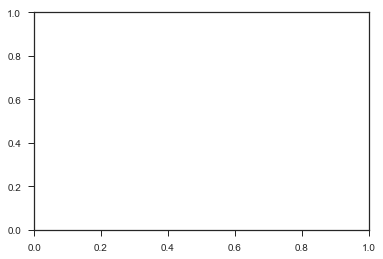

In [117]:
fig, ax = plt.subplots()
N = len(wide_variance_proj)
#TODO add the project RMSE only from wide_variance_proj
ind = np.arange(N)    # the x locations for the groups
width = 0.35         # the width of the bars
p1 = ax.bar(ind, rmse_unpool, width, color='r') #yerr =
p2 = ax.bar(ind + width, rmse_full_vary, width,color='y')
p3 = ax.bar(ind+2*width, rmse_pool, width, color='b')
ax.set_title('Unpooled vs Partial Pooled Errors (lower is better)')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(wide_variance_proj)

ax.legend((p1[0], p2[0], p3[0]), ('Unpooled', 'Partial Pool', 'Pooled'))
ax.yaxis.set_units('RMSE')
# ax.autoscale_view()


In [118]:
# this is me trying to estimate the improvement. 
# not sure (in fact pretty sure the other way) this is legit.
overall = 0
for i in range(10):
    diff = rmse_pool[i] - rmse_full_vary[i]
    overall = overall + (diff * diff)
total_diff = overall/10 # mean error change
print(total_diff)
np.average(rmse_full_vary)


0.3942512842548923


0.52302251877312789

This is a measure of *training* error: we validate our model against the same data it was trained on. This is satisfactory since we are looking for a simple estimate as to how effective the pooling/partial pooling decision was. In statistical learning, however, it is customary to separate data into training/test/validation sets. The test data can be simulated using a k-fold validation, which leaves out one tranche of the data as a test set, trains the model on the other tranches (k-1) and then calculates predictive error with respect to the held-out tranche. For ultimate validation, of course, we should be using our model on an entirely different data set, and testing predictive error on this hitherto unknown data.

# Deriving Thresholds from Partial Pooling 
In the original paper, thresholds were derived as follows:
1. If there was no significant difference between a given role (Controller) and the rest of the non-controller classes, then stop. Significant is derived from the non-parametric tests above.
2. **"Weight Ratio Calculation"**: for classes with that role, normalize class importance using LOC (i.e., shorter classes have a lower weight).
3. Order classes by weight ration.
4. Assign each class a cumulative weight consisting of the weights from classes that have smaller metric values.
4. Extract thresholds: the threshold for medium/high/highest metric value is taken from the class with a cumulative weight closest to 70/80/90% of the total, respectively. 

Another way of doing this is made possible by the model of lognormal. Simply find the 70/80/90% thresholds on the posterior probability distribution (where percentage is "of the total probability mass")

In [143]:
varying_intercept_slope_fit['sigma'].mean()

1.340778661863784

20.3426898804 31.1260285914 56.1425281664


10.070562961716185

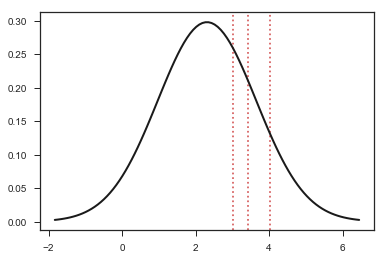

In [173]:
fig, ax = plt.subplots(1, 1)

# V2V
# c = 'V2V'
# c='tatami-team1'
c='2gx_demo'
mean = slopes_partial[project_lookup[c]]+intercepts_partial[project_lookup[c]]
sigma = varying_intercept_slope_fit['sigma'].mean() #for all projects

proj_model = stats.norm(loc=mean,scale=sigma)
x = np.linspace(proj_model.ppf(0.001),proj_model.ppf(0.999), 100)
low=proj_model.ppf(0.7)
med=proj_model.ppf(0.8)
high=proj_model.ppf(0.9)
plt.axvline(x=low,color='r', linestyle=':')
plt.axvline(x=med,color='r', linestyle=':')
plt.axvline(x=high,color='r', linestyle=':')
ax.plot(x, proj_model.pdf(x), 'k-', lw=2, label='frozen pdf')
print(np.exp(low),np.exp(med),np.exp(high))
np.exp(mean)

# Discussion
## Specific Thresholds
The conclusion of the original article \cite{aniche16} was that metrics for software should be thresholded (i.e., scored) based on the architectural role of the classes being measured. The broader point is that metrics are not one size fits all. This is equivalent to saying that a pooled, fixed effects model is nonsensical since it ignores context (fully pooled was our first example). The Bayesian multi-level model nicely supports this type of reasoning, and generalizes it to *any* context parameter of interest (these are merely levels in our model now). For example, we could easily extend this to consider language type, code age, number of committers, and so on. As Gelman et al state, a multilevel model should be the default approach to statistical modeing in software engineering.

Note too that in the weight ratio, LOC is effectively being used as a normalization parameter *anyway*, and it makes more sense to include that as a separate predictor instead.

What are the pragmatic implications for praticitioners? What we would say is that your company-specific measures should be weighted against global distributions for that metric. This is to some extent what consultancies like SIG do: they conduct a large number of metrics evaluations at different companies, stratify by industry segment (e.g. banking), and compare a *specific* value for one company (ING) against all other similar companies.

A common complaint about papers from e.g., Microsfot Research is that they are not applicable more broadly. While the authors personally find that extreme, a solution to this is to pool the MSR data with other existing datasets. 

# Related Work
1. Menzies, Local vs Global
2. Bettenburg,  n., Nagappan, M., "Think Locally, Act Globally: Improving Defect and Effort Prediction Models" - main difference is a much simpler (if more computationally expensive) multi-level model, and no clustering. Dpes the Menzies approach add some regularization (shrinkage), or is something else happenign? Argue for my approach being conceptually much simpler

# Model Checking
To validate the model we have chosen (i.e., the one defined in the partial pooling model example), we should check that the data it produces - the posterior distribution - matches with what we expect.

<a id='spikezero'></a>
# Extension: Modeling the spike at Zero

In addition to log-normal characteristics, software metrics have a tendency to occasinally have a spike at zero. If an object is not used in the codebase, for example, it will have no coupling. We can't just discard these, since they are clearly symptomatic of something. 

As [this post](https://robjhyndman.com/hyndsight/transformations/) suggests, the approach taken above---taking log(n+1) - is probably ok, but does make some weirdness happen. In this section we examine how a *mixture model* can characterize what is happening. THe 'mixture' part is just the fact that we will model the zero spike separately from the rest of the data. 

## Extension: Modeling with Two Predictors
In our worked example, we only used a single predictor: architecutal role. However, we know from various studies that source lines of code are a common covariant with many software metrics. In the CBO (coupling) metric, we would expect that longer files would have more calls to external code, and thus more coupling. In this extension, we will apply a double predictor model to our previous models.

THe main cahnge is to use a matrix representation for our data, instead of a single value. Our matrix is 2 columns, one for the file's LOC measure, and one for the CBO measure. Our pooled regression model looks like

$ y_i = \alpha + \beta_1 \text{loc}_i + \beta_2 \text{cbo}_i + \epsilon $

see https://jrnold.github.io/bayesian_notes/introduction-to-stan-and-linear-regression.html

In [ ]:
find_fit.plot_fits(pandas.Series(log_sloc),title='SLOC scores with best fit distribution', xlab='SLOC score')

## Why Not KS (Kolmogorov-Smirnov)?
One way to assess model fit is to run a KS test of model fit. KS measures the distance between your sample data and the theoretical distribution. 

Thanks to https://seaborn.pydata.org/tutorial/categorical.html and https://github.com/fonnesbeck/stan_workshop_2016/blob/master/notebooks/Multilevel%20Modeling.ipynb